## Simulador PGBL x VGBL
- tutorial por @victordhn

Nesse código vamos simular um plano de previdência privada no formato VGBL e PGBL, progressivo e regressivo. Objetivo é comparar o retorno de todas as opções, inclusive contando com o benefício fiscal que o PGBL oferece

### Pontos importantes:
- A expectativa de vida utilizada no modelo é de 80 anos.
- Podem haver algumas pequenas imprecisões no cálculo do imposto, e algumas simplificações no modelo, mas no geral, o resultado está fiel à realidade aplicada em bancos
- O modelo não permite aplicação simultânea em 2 tipos de planos, mas é regra de ouro é: aplique em PGBL até o limite da dedução possível no IR (12%) e o resto invista em VGBL 
- O resultado acima fica claro nos resultados. O VGBL é superior se não levarmos em conta o benefício fiscal. Se o benefício fiscal do PGBL for considerado, o PGBL se torna superior até o limite da dedução.
- O código está todo no formato de funções. No final do código temos a função master "modelo" que roda todas subfunções de uma vez.

### Libraries utilizadas:
- numpy
- matplotlib
- bcb (pacote do banco central do brasil)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
# !pip install python-bcb
from bcb import sgs

### Inputs do modelo:

In [31]:
def inputs():
    global idade
    global tempo
    global renda
    global aporte
    global rendimento
    global taxa
    
    idade = int(input("Qual é a sua idade: "))
    tempo = int(input("Por quantos anos você pretende contribuir para o plano: "))
    renda = float(input("Qual é o valor da sua renda mensal: "))
    aporte = int(input("Qual valor você pretende aportar mensalmente?: "))
    rendimento = input("Você deseja especificar algum rendimento esperado do investimento? Digite 1 para específicar o rendimento ou 0 para utilizar a taxa SELIC atual: ")
    if rendimento == "1":
        taxa = float(input("Digite o valor do rendimento esperado (apenas números e virgulas, exemplo: 12.5): " ))
    print()

---
### Regime tributário progressivo:

- Importante, para idosos, as faixas de isenção na tributação progressiva previdenciária são estendidas em 1903 reais, logo usaremos essa faixa estendida no cálculo do imposto nos saques pelo regime progressivo. 

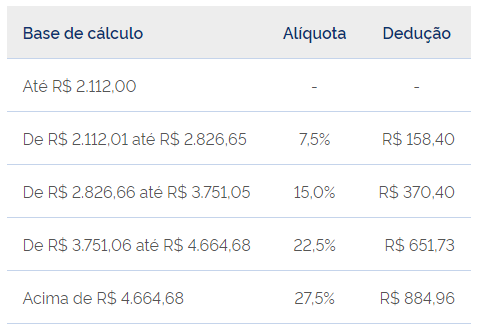
- Rendimentos previdenciários isentos para maiores de 65 anos: R$ 1.903,98



In [32]:
def progressivo_taxas():
    
    global progressivo_faixa
    global progressivo_deducao
    global progressivo_taxa
    global progressivo_idoso
    
    progressivo_faixa = [2112,2826.66,3751.06,4664.68]
    progressivo_deducao = [158.4,370.4,651.73,884.96]
    progressivo_taxa = [0.075,0.15,0.225,0.275]
    progressivo_idoso = [x+1903.98 for x in progressivo_faixa]

### Regime tributário regressivo:
- Para todos os efeitos deste exercício, vamos considerar que o imposto pago nos saques pelo sistema regressivo sempre será a taxa respectiva a totalidade de anos que o contribuinte aportou.

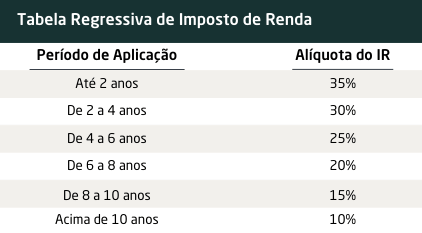

In [33]:
def regressivo_taxas():
    
    global regressivo_tempo
    global regressivo_tax
    
    regressivo_tempo = [0,2,4,6,8,10]
    regressivo_tax = [0.35,0.30,0.25,0.20,0.15,0.10]

In [34]:
def taxas():
    progressivo_taxas()
    regressivo_taxas()

---
### Período de contribuição

- Buscando o valor atual da SELIC para usar como parâmetro para evolução do valor dos aportes.
- Nós adicionamos a opção do operador (ou cliente) alterar o rendimento esperado no plano. Isso é importante para momentos onde a SELIC está instável (seja muita alta e com expectativa de queda, ou muito baixa com expectativa de alta)

In [35]:
def rendimentos():
    
    global juros_mensal
    global taxa
    
    if rendimento == '1':
        juros_mensal = (taxa/100+1)**(1/12)
    else:
        selic = sgs.get(('selic', 432))
        taxa = (selic.iloc[-1,0]/100)+1
        juros_mensal = taxa**(1/12)

- Aqui iremos saber por quanto tempo o indivíduo irá contribuir. 
- Para calcular o valor saque dos benefícios após o período de contribuição, iremos utilizar uma estimativa de 80 anos para a expectativa de vida do contribuinte.
- Por exemplo: se o contribuinte tem 45 anos e pretende contribuir por mais 20, ele terá 15 anos receber o benefício até completar os 80 anos.
- Coletaremos o valor do aporte, e iremos calcular o valor acumulado disponível no momento da aposentadoria.

In [36]:
def calculo_contribuicao():
    
    global meses
    global vida
    global aportes
    global retornos
    global periodos
    global acumulado
    
    meses = (tempo)*12
    vida = (80-(idade+tempo))*12

    aportes = np.ones(meses)*aporte

    retornos = []
    periodos = []
    
    for i in range(meses):
        acumulado = 0
        j = 0
        while i >= j:
            aportes[j]=aportes[j]*juros_mensal
            acumulado = acumulado+aportes[j]
            j += 1
        retornos.append(acumulado)
        periodos.append(i)
    
    acumulado = retornos[-1]
    acumulado
    print(f"O valor acumulado durante os {tempo} anos de contribuição será de R${acumulado:.2f}")

- Valor plotar a evolução do valor acumulado com os aportes ao longo do tempo de contribuição

In [37]:
def plot_saldo():    
    plt.figure(figsize=(6, 3))
    plt.plot(periodos, retornos, label=f'Valor acumulado em {tempo} anos: R$ {acumulado:.2f}')
    plt.ticklabel_format(style='plain')
    plt.xlabel('Períodos (meses)')
    plt.ylabel('Valor acumulado (R$)')
    plt.title('Período de acumulação', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
def contribuicao():
    rendimentos()
    calculo_contribuicao()
    plot_saldo()

---
### Período de usufruto (saques)

- Para calcular o valor que o beneficiário irá sacar cada mês, utilizaremos a expectativa de vida de 80 anos do modelo, e veremos quantos meses o beneficiário terá para saque.

- Então iremos calcular o valor das retiradas mensais, enquanto o valor remanescente continua rendendo juros periódicos

- Vamos fazer um sistema recursivo para descobrir o valor do saque:


- (1) Vamos 'chutar' o primeiro valor: o total acumulado dividido pelo número de meses
- (2) Vamos então rodar o código e ver se, ao final do cálculo, o saldo disponível ficou negativo
- (3) Caso esteja negativo, quer dizer que chutamos alto, então reduziremos o nosso chute em 10%. 
- (4) Caso o valor final seja positivo, podemos ter chutado baixo demais, então aumentaremos o chute em 10%.
- (5) O sistema irá para quando o valor acumulado restante após os saques seja entre +/- 1% do valor inicial acumulado (positivos ou negativos)

- Essa é uma aproximação razoável pois implica em realizar 1 ou 2 saques a mais ou a menos apenas, dentro de um universo de vários anos

In [50]:
def calculo_usufruto():
    
    global acumulado
    global benchmark
    global restante
    global saque

    acumulado = retornos[-1]
    benchmark = acumulado*0.01
    restante = [9999999]
    saque = acumulado/vida

    while restante[-1] > benchmark or restante[-1] < -1*benchmark:
        restante = []
        acumulado = retornos[-1]
        for i in range(vida):
            saque
            restante.append((acumulado-saque)*juros_mensal)
            acumulado = (acumulado-saque)*juros_mensal
        if restante[-1] > benchmark:
            saque = saque*1.1
        elif restante[-1] < -1*benchmark:
            saque = saque*0.9
    acumulado = retornos[-1]
    print(f'O valor do saque mensal bruto disponível será de: R${saque:.2f}')

- Vamos plotar o decaimento do valor acumulado com os saques ao longo do tempo de usufruto

In [40]:
def plot_saque(): 
    periodo2 = list(range(vida))
    plt.figure(figsize=(6, 3))
    plt.plot(periodo2, restante, label=f'Saque mensal bruto de R${saque:.2f} reais')
    plt.ticklabel_format(style='plain')
    plt.xlabel('Períodos (meses)')
    plt.ylabel('Valor acumulado (R$)')
    plt.title(f'Período de usufruto', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
def usufruto():
    calculo_usufruto()
    plot_saque()

### Valor do saque: PGBL x VGBL

- Para facilitar o cálculo do imposto no VGBL, que incide apenas sobre os rendimentos, vou calcular a proporção entre o rendimento e o aporte, e aplicarei essa proporção em os saques mensais.
- 82% do total do valor acumulado no plano é composto pelos rendimentos do investimento.

In [42]:
# total de aportes
def calculo_porcentagem():

    global porcentagem
    
    total_aporte = aporte*meses
    total_rendimento = acumulado-total_aporte
    porcentagem = total_rendimento/acumulado
    
    print("----- Rendimentos ------")
    print(f'A porcentagem do total do valor acumulado correspondente aos rendimentos é de {porcentagem*100:.2f}%')
    print()

#### VGBL progressivo x regressivo
- imposto apenas sobre o rendimento

In [43]:
def vgbl_calculo():
    
    global vgbl_progressivo
    global vgbl_regressivo
    
    # Progressivo, utilizando a taxa de idosos
    vgbl_progressivo = 0
    for i in range(4):
        if saque*porcentagem >= progressivo_idoso[i]:
            vgbl_progressivo = progressivo_taxa[i]*(saque*porcentagem)-progressivo_deducao[i]
    print("--------- VGBL ---------")
    print(f'O valor do imposto no VGBL progressivo é de R${vgbl_progressivo:.2f}')
    print(f'O valor do saque mensal líquido no VGBL progressivo é de R${saque-vgbl_progressivo:.2f}')
    print(f'O valor total dos saques líquidos no VGBL progressivo é de R${(saque-vgbl_progressivo)*vida:.2f}')
    print()
    
    # Regressivo
    vgbl_regressivo = 0
    for i in range(6):
        if tempo < regressivo_tempo[i]:
            vgbl_regressivo = regressivo_tax[i]*(saque*porcentagem)
            break
        else:
            vgbl_regressivo = regressivo_tax[-1]*(saque*porcentagem)
    print(f'O valor do imposto no VGBL regressivo é de R${vgbl_regressivo:.2f}')
    print(f'O valor do saque líquido no VGBL regressivo é de R${saque-vgbl_regressivo:.2f}')
    print(f'O valor total dos saques líquidos no VGBL regressivo é de R${(saque-vgbl_regressivo)*vida:.2f}')
    print()


#### PGBL progressivo x regressivo
- imposto apenas sobre o valor total

In [44]:
def pgbl_calculo():   
    
    global pgbl_progressivo
    global pgbl_regressivo
    
    # Progressivo, utilizando a taxa de idosos
    pgbl_progressivo = 0
    for i in range(4):
        if saque*porcentagem >= progressivo_idoso[i]:
            pgbl_progressivo = progressivo_taxa[i]*(saque)-progressivo_deducao[i]
    print("--------- PGBL ---------")
    print(f'O valor do imposto no PGBL progressivo é de R${pgbl_progressivo:.2f}')
    print(f'O valor do saque líquido no PGBL progressivo é de R${saque-pgbl_progressivo:.2f}')
    print(f'O valor total dos saques líquidos no PGBL progressivo é de R${(saque-pgbl_progressivo)*vida:.2f}')
    print()

    # Regressivo
    pgbl_regressivo = 0
    for i in range(6):
        if tempo < regressivo_tempo[i]:
            pgbl_regressivo = regressivo_tax[i]*(saque)
            break
        else:
            pgbl_regressivo = regressivo_tax[-1]*(saque)
    print(f'O valor do imposto no PGBL regressivo é de R${pgbl_regressivo:.2f}')
    print(f'O valor do saque líquido no PGBL regressivo é de R${saque-pgbl_regressivo:.2f}')
    print(f'O valor total dos saques líquidos no PGBL regressivo é de R${(saque-pgbl_regressivo)*vida:.2f}')
    print()

### Benefício Fiscal do PGBL
- O PGBL permite que você deduza o valor da sua contribuição no seu imposto de renda, até o limite de 12% da sua renda declarada

In [45]:
def benef_fiscal():
    
    global deducao_maxima
    global beneficio_fiscal
    
    # renda = float(input("Qual é o valor da sua renda mensal: "))
    deducao_maxima = renda*0.12
    beneficio_fiscal = 0
    print("--- Benefício Fiscal ---")
    if aporte < deducao_maxima:
        print(f'Você poderá deduzir o seu aporte completo de R${aporte:.2f} do seu IRPF')
        print(f'O seu benefício fiscal total será de R${aporte*meses:.2f}')
        print()
        beneficio_fiscal = aporte*meses
    else:
        print(f'Você só poderá deduzir R${deducao_maxima:.2f} do seu IRPF')
        print(f'O seu benefício fiscal total será de R${deducao_maxima*meses:.2f}')
        print()
        beneficio_fiscal = deducao_maxima*meses

- Somando o benefício fiscal aos saques efetuados no período de usufruto e comparando com a opção do VGBL temos os seguintes cenários:

In [46]:
def pgbl_beneficios():
    # PGBL progressivo e regressivo + benefício fiscal
    print(f'O valor total dos saques líquidos + benefício fiscal no PGBL progressivo é de R${(saque-pgbl_progressivo)*vida+beneficio_fiscal:.2f}')
    print(f'O valor total dos saques líquidos + benefício fiscal no PGBL regressivo é de R${(saque-pgbl_regressivo)*vida+beneficio_fiscal:.2f}')
    print()

In [47]:
def calculo_planos():
    calculo_porcentagem()
    vgbl_calculo()
    pgbl_calculo()
    benef_fiscal()
    pgbl_beneficios()

---
### Resultados:

In [48]:
def modelo():
    inputs()
    taxas()
    contribuicao()
    usufruto()
    calculo_planos()

Qual é a sua idade: 35
Por quantos anos você pretende contribuir para o plano: 30
Qual é o valor da sua renda mensal: 6000
Qual valor você pretende aportar mensalmente?: 600
Você deseja especificar algum rendimento esperado do investimento? Digite 1 para específicar o rendimento ou 0 para utilizar a taxa SELIC atual: 1
Digite o valor do rendimento esperado (apenas números e virgulas, exemplo: 12.5): 7

O valor acumulado durante os 30 anos de contribuição será de R$705638.91


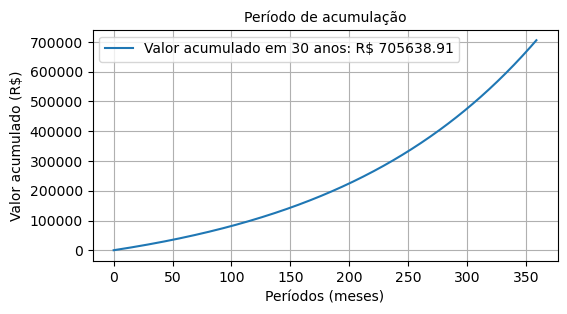

O valor do saque mensal bruto disponível será de: R$6218.04


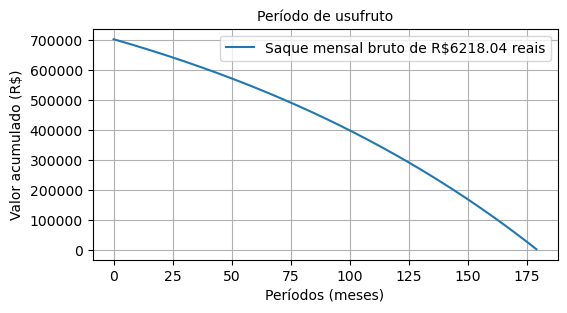

----- Rendimentos ------
A porcentagem do total do valor acumulado correspondente aos rendimentos é de 69.39%

--------- VGBL ---------
O valor do imposto no VGBL progressivo é de R$165.20
O valor do saque mensal líquido no VGBL progressivo é de R$6052.84
O valor total dos saques líquidos no VGBL progressivo é de R$1089510.65

O valor do imposto no VGBL regressivo é de R$431.47
O valor do saque líquido no VGBL regressivo é de R$5786.57
O valor total dos saques líquidos no VGBL regressivo é de R$1041582.68

--------- PGBL ---------
O valor do imposto no PGBL progressivo é de R$307.95
O valor do saque líquido no PGBL progressivo é de R$5910.08
O valor total dos saques líquidos no PGBL progressivo é de R$1063815.08

O valor do imposto no PGBL regressivo é de R$621.80
O valor do saque líquido no PGBL regressivo é de R$5596.23
O valor total dos saques líquidos no PGBL regressivo é de R$1007321.92

--- Benefício Fiscal ---
Você poderá deduzir o seu aporte completo de R$600.00 do seu IRPF
O s

In [51]:
modelo()